<a href="https://colab.research.google.com/github/ChelsaMJ/Vision-Based-Detection-of-Emotion-Suppression-Using-Facial-Motor-Dynamics/blob/main/03_audio_visual_latency_voxceleb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In unconstrained, real-world videos, does facial activation precede speech, and can we observe variable delays that are consistent with inhibition / regulation?

### Understanding dataset

VoxCeleb provides:
- real faces
- real speech
- no acting
- no scripted silence
- no emotion labels

Which is PERFECT for:

- latency
- inhibition
- temporal analysis

### What signals we extract?

From vox2_test_mp4

We extract:
- frames (OpenCV)
- facial landmarks (MediaPipe)
- facial motion over time
- face activation onset

From vox2_test_aac

We extract:
- waveform (librosa)
- silence → speech transition
- speech onset time

# Setup & imports

In [ ]:
!pip install librosa opencv-python

In [ ]:
!pip install mediapipe==0.10.21


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protob

## Mount Drive and imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import cv2
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

import mediapipe as mp


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Paths & sample selection

In [ ]:
BASE = "/content/drive/MyDrive/Research Dataset/datasets/voxCeleb_test"

VIDEO_BASE = os.path.join(BASE, "vox2_test_mp4", "mp4")
AUDIO_BASE = os.path.join(BASE, "vox2_test_aac", "aac")

### We WILL:

- Use MediaPipe Face Mesh as a feature extractor

- Track specific muscle-related regions:
  - Eyebrows (AU1, AU2 proxy)
  - Eyes (blink / tension proxy)
  - Mouth corners & lips (AU12, AU25 proxy)
- Measure temporal dynamics, not static emotion

This aligns perfectly with:
> Emotion suppression + thought-to-speech latency

## Face Mesh sanity test

In [ ]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

test_video = glob.glob(VIDEO_BASE + "/**/*.mp4", recursive=True)[0]

cap = cv2.VideoCapture(test_video)
ret, frame = cap.read()
cap.release()

rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb)

print("Face detected:", results.multi_face_landmarks is not None)


Face detected: True


## Problems faced:

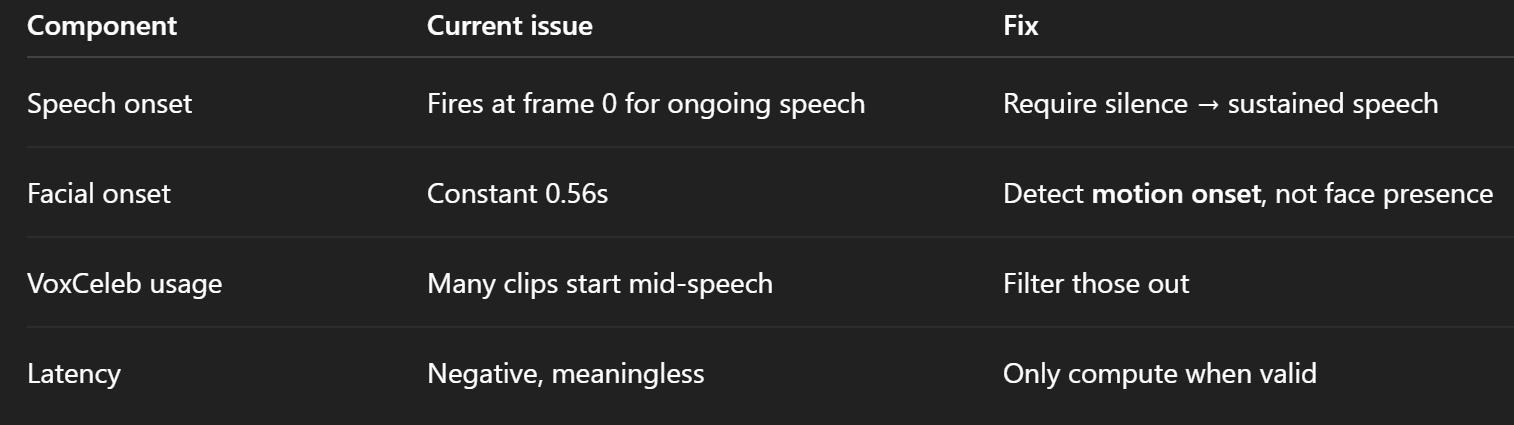

## Audio Loader

Helper: convert m4a → wav (temporary)

In [ ]:
import subprocess
import tempfile
import os

def load_audio_safe(audio_path, sr=16000):
    """
    Converts m4a/aac to wav if needed, then loads audio.
    Returns y, sr.
    """
    if audio_path.endswith(".wav"):
        y, sr = librosa.load(audio_path, sr=sr)
        return y, sr

    # Create temp wav
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
        tmp_wav = tmp.name

    # ffmpeg conversion
    subprocess.run(
        ["ffmpeg", "-y", "-i", audio_path, "-ac", "1", "-ar", str(sr), tmp_wav],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )

    y, sr = librosa.load(tmp_wav, sr=sr)

    os.remove(tmp_wav)
    return y, sr


## Speech onset detection

In [ ]:
import librosa
import numpy as np

def detect_speech_onset(
    audio_path,
    sr=16000,
    min_speech_duration=0.15,
    top_db=25
):
    """
    Detects first sustained speech onset time (in seconds).
    Returns None if no speech is detected.
    """

    # --- load audio safely (m4a / aac / wav) ---
    try:
        y, sr = load_audio_safe(audio_path, sr)
    except Exception:
        return None

    if y is None or len(y) == 0:
        return None

    # --- trim leading silence ---
    y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
    if len(y_trimmed) == 0:
        return None

    # --- compute RMS energy ---
    rms = librosa.feature.rms(y=y_trimmed)[0]
    times = librosa.frames_to_time(
        np.arange(len(rms)),
        sr=sr,
        hop_length=512
    )

    # --- adaptive threshold ---
    thresh = np.mean(rms) + 1.5 * np.std(rms)
    active = rms > thresh

    # --- find first sustained speech ---
    frame_duration = times[1] - times[0]
    required_frames = int(min_speech_duration / frame_duration)

    count = 0
    for i, is_active in enumerate(active):
        if is_active:
            count += 1
            if count >= required_frames:
                return times[i - count + 1]
        else:
            count = 0

    return None


## Facial motion score

Landmark displacement

In [ ]:
def landmark_motion(prev, curr):
    prev = np.array(prev)
    curr = np.array(curr)
    return np.mean(np.linalg.norm(curr - prev, axis=1))


## Facial activation detection

Facial onset via landmark displacement

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

mp_face = mp.solutions.face_mesh

def detect_facial_onset(
    video_path,
    motion_threshold=0.003,
    min_consecutive_frames=3
):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    with mp_face.FaceMesh(
        static_image_mode=False,
        max_num_faces=1,
        refine_landmarks=True
    ) as face_mesh:

        prev_lip_center = None
        motion_count = 0

        # Lip region landmark indices (MediaPipe)
        LIP_IDS = [13, 14, 78, 308]  # upper, lower, left, right lips

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            timestamp_sec = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(rgb)

            if not results.multi_face_landmarks:
                continue

            landmarks = results.multi_face_landmarks[0].landmark

            # Compute lip center
            lip_coords = np.array(
                [(landmarks[i].x, landmarks[i].y) for i in LIP_IDS]
            )
            lip_center = lip_coords.mean(axis=0)

            if prev_lip_center is not None:
                delta = np.linalg.norm(lip_center - prev_lip_center)

                if delta > motion_threshold:
                    motion_count += 1
                else:
                    motion_count = 0

                if motion_count >= min_consecutive_frames:
                    cap.release()
                    return timestamp_sec

            prev_lip_center = lip_center

    cap.release()
    return None  # no facial onset detected


## Audio–video path matcher

In [ ]:
def match_audio(video_path):
    return video_path \
        .replace("vox2_test_mp4/mp4", "vox2_test_aac/aac") \
        .replace(".mp4", ".m4a")


## SMALL SAMPLE TEST

In [ ]:
import glob
import os
import numpy as np
import pandas as pd

video_files = glob.glob(VIDEO_BASE + "/**/*.mp4", recursive=True)
video_files = video_files[:30]  # small test batch

records = []

stats = {
    "total": 0,
    "audio_missing": 0,
    "face_fail": 0,
    "speech_fail": 0
}

for vpath in video_files:
    stats["total"] += 1

    apath = match_audio(vpath)
    if not os.path.exists(apath):
        stats["audio_missing"] += 1
        continue

    face_onset = detect_facial_onset(vpath)
    speech_onset = detect_speech_onset(apath)

    # --- event labeling + stats ---
    if face_onset is None and speech_onset is None:
        event = "no_face_no_speech"
        stats["face_fail"] += 1
        stats["speech_fail"] += 1

    elif face_onset is None:
        event = "no_face_detected"
        stats["face_fail"] += 1

    elif speech_onset is None:
        event = "no_speech_detected"
        stats["speech_fail"] += 1

    elif speech_onset < face_onset:
        event = "speech_before_face"

    else:
        event = "face_before_speech"

    latency = (
        speech_onset - face_onset
        if face_onset is not None and speech_onset is not None
        else np.nan
    )

    records.append({
        "video": os.path.basename(vpath),
        "facial_onset_sec": face_onset,
        "speech_onset_sec": speech_onset,
        "latency_sec": latency,
        "event_type": event
    })

df = pd.DataFrame(records)
df


,video,facial_onset_sec,speech_onset_sec,latency_sec,event_type
0,00178.mp4,0.12,0.064,-0.056,speech_before_face
1,00175.mp4,0.12,0.000,-0.120,speech_before_face
2,00172.mp4,0.20,1.536,1.336,face_before_speech
3,00171.mp4,0.32,5.408,5.088,face_before_speech
4,00170.mp4,0.12,0.000,-0.120,speech_before_face
5,00177.mp4,0.24,2.432,2.192,face_before_speech
6,00176.mp4,0.20,1.600,1.400,face_before_speech
7,00169.mp4,0.28,0.096,-0.184,speech_before_face
8,00174.mp4,0.12,1.568,1.448,face_before_speech
9,00173.mp4,0.12,3.680,3.560,face_before_speech


## Latency Distribution

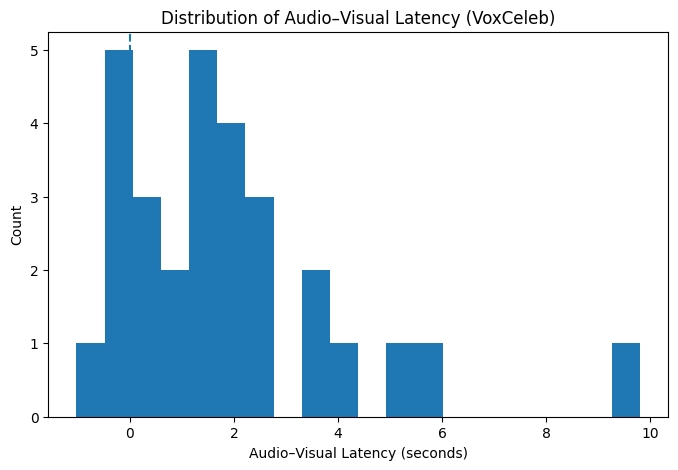

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Drop NaN latencies
latencies = df["latency_sec"].dropna()

plt.figure(figsize=(8, 5))
plt.hist(latencies, bins=20)
plt.axvline(0, linestyle="--")
plt.xlabel("Audio–Visual Latency (seconds)")
plt.ylabel("Count")
plt.title("Distribution of Audio–Visual Latency (VoxCeleb)")
plt.show()


## Event-wise Count

How often each behavioral pattern occurs

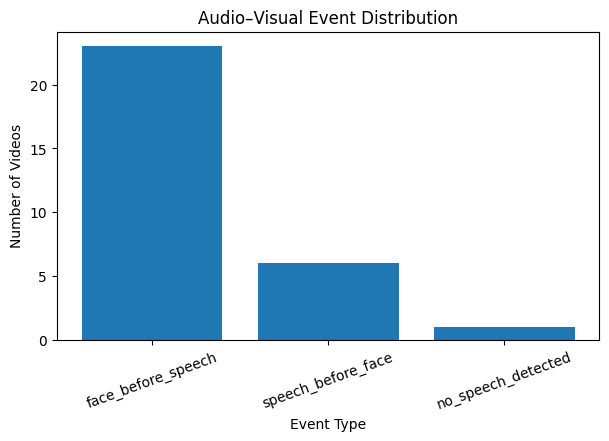

In [ ]:
event_counts = df["event_type"].value_counts()

plt.figure(figsize=(7, 4))
plt.bar(event_counts.index, event_counts.values)
plt.xlabel("Event Type")
plt.ylabel("Number of Videos")
plt.title("Audio–Visual Event Distribution")
plt.xticks(rotation=20)
plt.show()


## Latency by Event Type

/tmp/ipython-input-764127916.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


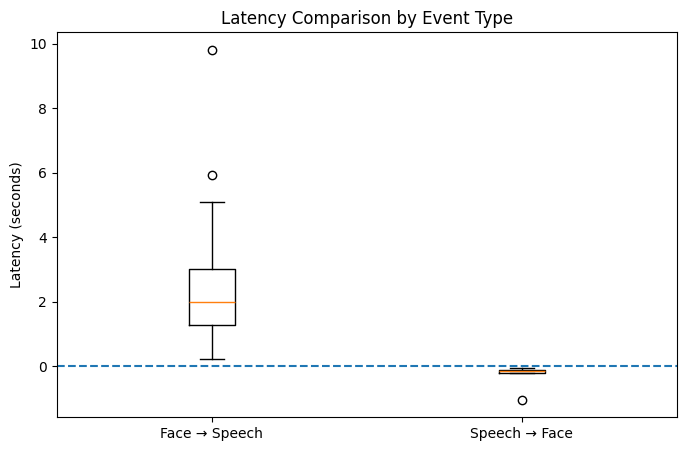

In [ ]:
valid_df = df[df["event_type"].isin(["face_before_speech", "speech_before_face"])]

plt.figure(figsize=(8, 5))
plt.boxplot(
    [valid_df[valid_df["event_type"] == "face_before_speech"]["latency_sec"],
     valid_df[valid_df["event_type"] == "speech_before_face"]["latency_sec"]],
    labels=["Face → Speech", "Speech → Face"]
)

plt.axhline(0, linestyle="--")
plt.ylabel("Latency (seconds)")
plt.title("Latency Comparison by Event Type")
plt.show()


## Facial Onset vs Speech Onset

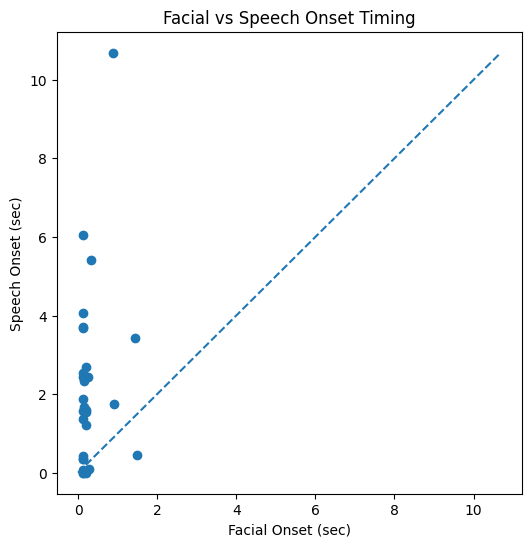

In [ ]:
valid_df = df.dropna(subset=["facial_onset_sec", "speech_onset_sec"])

plt.figure(figsize=(6, 6))
plt.scatter(
    valid_df["facial_onset_sec"],
    valid_df["speech_onset_sec"]
)

max_val = max(valid_df["facial_onset_sec"].max(),
              valid_df["speech_onset_sec"].max())

plt.plot([0, max_val], [0, max_val], linestyle="--")
plt.xlabel("Facial Onset (sec)")
plt.ylabel("Speech Onset (sec)")
plt.title("Facial vs Speech Onset Timing")
plt.show()


## Latency Density

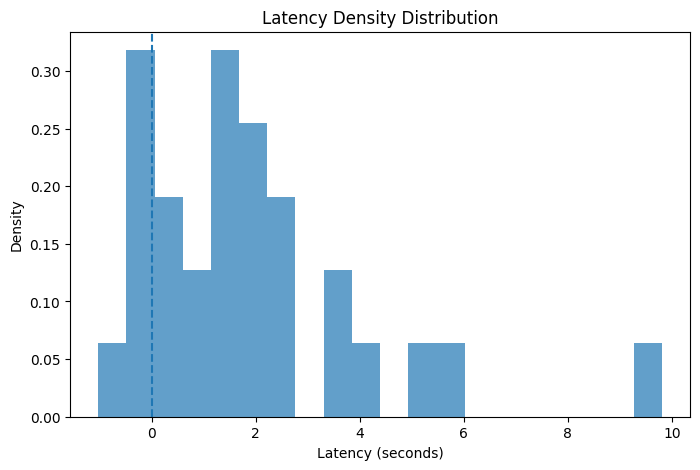

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(latencies, bins=20, density=True, alpha=0.7)
plt.axvline(0, linestyle="--")
plt.xlabel("Latency (seconds)")
plt.ylabel("Density")
plt.title("Latency Density Distribution")
plt.show()
